<a href="https://colab.research.google.com/github/TalCordova/TensorFlow_Course/blob/main/05_transfer_learning_with_tensorflow_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Par 2: Fine-Tuning

In the previous notebook, we covered transfered learning feature extraction, now it's time to learn about a new kind of tranfer learning: fine-tuning.

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Thu Nov 17 15:16:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |   4978MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script. You can download and import imto your notebooks (or elsewhere).

We've done this for some of our functions we've used previously here https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-17 15:16:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-17 15:16:41 (79.0 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebbok
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how to use the pretrined models within `tf.keras.applications` and apply them to our own problem (recognizizng images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-11-17 15:16:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   305MB/s    in 0.5s    

2022-11-17 15:16:41 (305 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# Check out our many images and sub-directories in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names for our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an exapmle of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.34183645e+00 5.34183645e+00 0.00000000e+00]
   [6.00000000e+00 5.00000000e+00 6.88775301e-01]
   [7.95918465e-01 7.95918465e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.26530600e+00 3.26530600e+00 1.93877459e-01]
   [1.42856598e-01 1.14285660e+00 0.00000000e+00]
   [2.64285731e+00 1.42857170e+00 2.29591981e-01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[9.06122398e+00 8.84693909e+00 6.41836643e+00]
   [9.84692991e-01 4.13264692e-01 5.61222248e-02]
   [5.42857170e+00 1.26020432e+00 9.18368399e-02]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[9.39285736e+01 8.19285736e+01 8.59285736e+01]
   [9

## Model 0: Building a transfer learning model feature extraction using Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layers")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs into base model
x = base_model(inputs)
print(f"Shape after passing input through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_model_extraction")])

Shape after passing input through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_model_extraction/20221117-151646
Epoch 1/5
24/24 [==============================] - 14s 255ms/step - loss: 1.8600 - accuracy: 0.4280 - val_loss: 1.2832 - val_accuracy: 0.7303
Epoch 2/5
24/24 [==============================] - 5s 188ms/step - loss: 1.0804 - accuracy: 0.7627 - val_loss: 0.8638 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 5s 186ms/step - loss: 0.7888 - accuracy: 0.8133 - val_loss: 0.6790 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 4s 155ms/step - loss: 0.6404 - accuracy: 0.8547 - val_loss: 0.5907 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 5s 186ms/step - loss: 0.5508 - accuracy: 0.8667 - val_loss: 0.5348 - val_accuracy: 0.8734


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5575 - accuracy: 0.8628


[0.5574588775634766, 0.8628000020980835]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_7
1 rescaling_6
2 normalization_6
3 tf.math.truediv_6
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_7[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_6 (Normalization  (None, None, None,   7          ['rescaling_6[0][0]']            
 )                              3)                                                   

In [ ]:
# How about a summary of our own model
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


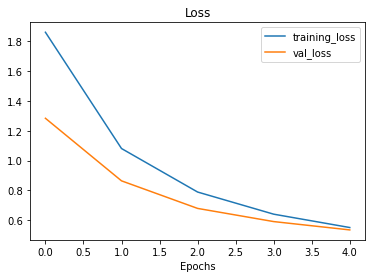

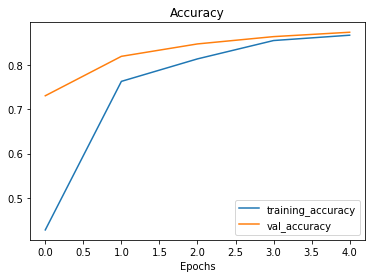

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Sverage 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAvergae2D it turns into (None, 1280).

Let's use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global avergae pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global avergae pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the Global Average Pool 2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of tranfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction trsnfer learning with 1% of the training data with data augmentation
2. `model_2` -  use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fune-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning trasnfer learning on 100% of the training data with data augmentation

### Getting and preprocessing data for `model_1`

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-11-17 15:17:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  86.1MB/s    in 1.5s    

2022-11-17 15:17:32 (86.1 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we're working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#option_2_apply_the_preprocessing_layers_to_your_dataset

Off of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than CPU.
* Image data augmentation only happens during training, so we can still export out whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping, rotations, zooms, etc
data_augmentation =  keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name = "data_augmentation")

### Visualize our data augmentation layer and see what happens to our data

(-0.5, 553.5, 415.5, -0.5)

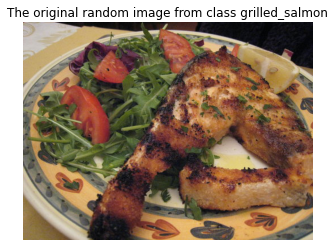

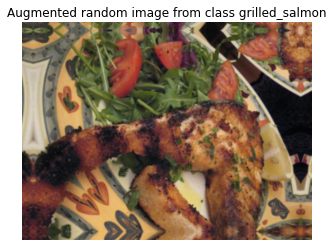

In [ ]:
# View a random image and compare it to its agmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"The original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation



In [ ]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input lauer
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the inputs (after they've been augmented) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "gloabal_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training log
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221117-151737
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4786 - accuracy: 0.0714 - val_loss: 2.2262 - val_accuracy: 0.1661
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1609 - accuracy: 0.2714 - val_loss: 2.1132 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 2s 1s/step - loss: 1.9242 - accuracy: 0.4571 - val_loss: 1.9753 - val_accuracy: 0.3503
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7891 - accuracy: 0.5286 - val_loss: 1.8840 - val_accuracy: 0.3947
Epoch 5/5
3/3 [==============================] - 2s 1s/step - loss: 1.5882 - accuracy: 0.7000 - val_loss: 1.7965 - val_accuracy: 0.4556


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabal_average_pooling_lay  (None, 1280)             0         
 er (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.7692 - accuracy: 0.4912


[1.7691580057144165, 0.4912000000476837]

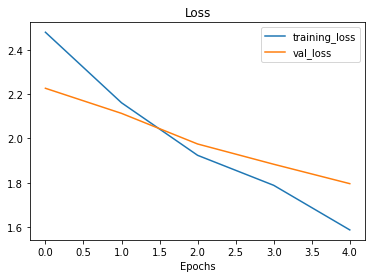

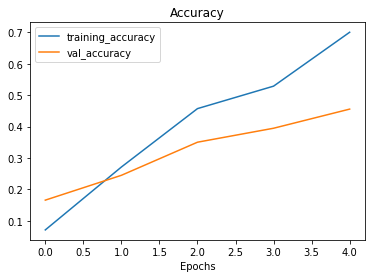

In [ ]:
# How do the model with 1% of the data and data augmentation Loss curves
plot_loss_curves(history_1_percent)

## Model 2: feature extraction learning model with 10% of data and data augmentation


In [ ]:
# Get the 10% of data... uncomment if you don't have it
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# How many images in our directory
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2 you'll need to rescale your data, EfficientNet had rescalining built in
], name = "data_augmentation")

# Setup the input shape to pur model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_mdoel = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and output (including the layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training = False) # we pass the augmented images to base model but keep it in inference mode, this also insure batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a model checkpoint callbacks

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_feq = "epochs", # save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs = initial_epochs,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_data_aug"),
                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221117-151812
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9908 - accuracy: 0.3533
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 14s 347ms/step - loss: 1.9908 - accuracy: 0.3533 - val_loss: 1.4211 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2980 - accuracy: 0.7120
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 7s 295ms/step - loss: 1.2980 - accuracy: 0.7120 - val_loss: 0.9710 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.7693
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 6s 220ms/step - loss: 0.9959 - accuracy: 0.7693 - val_loss: 0.7945 - val_accuracy: 0.8191
Epoch 

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.5575 - accuracy: 0.8628


[0.5574588179588318, 0.8628000020980835]

In [ ]:
# Check model 2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6139 - accuracy: 0.8448


[0.6139374375343323, 0.8447999954223633]

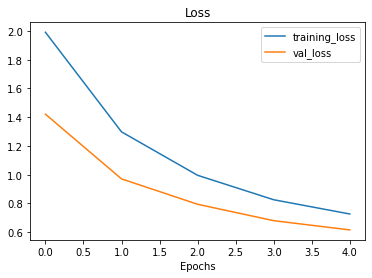

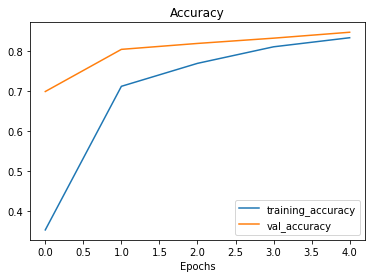

In [ ]:
# Plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpointed weights
Loading in checkointed weigths returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evalaute model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6139 - accuracy: 0.8448


In [ ]:
# If the ressults from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check to see if loaded model results are very close to our previous non loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Arae these trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa8c2ef4790> True
<keras.engine.sequential.Sequential object at 0x7fa8c2ef4610> True
<keras.engine.functional.Functional object at 0x7fa924c9da50> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa8c2eba1d0> True
<keras.layers.core.dense.Dense object at 0x7fa8c2a3f150> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 tf.math.truediv_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine-tuning  you typically want to lower learning rate by 10x
              metrics = ["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 tf.math.truediv_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Now we've unfrozen some of the layers cloase to the top, how many tainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same the model _2 except with more trainable layer)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_2.epoch[-1],
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")]) # start training from previous last epoch
                                               

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221117-151931
Epoch 5/10
24/24 [==============================] - 14s 322ms/step - loss: 0.6265 - accuracy: 0.8213 - val_loss: 0.4788 - val_accuracy: 0.8503
Epoch 6/10
24/24 [==============================] - 6s 240ms/step - loss: 0.5259 - accuracy: 0.8413 - val_loss: 0.4662 - val_accuracy: 0.8470
Epoch 7/10
24/24 [==============================] - 7s 285ms/step - loss: 0.4386 - accuracy: 0.8720 - val_loss: 0.4333 - val_accuracy: 0.8651
Epoch 8/10
24/24 [==============================] - 7s 272ms/step - loss: 0.3991 - accuracy: 0.8813 - val_loss: 0.4429 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 7s 262ms/step - loss: 0.3484 - accuracy: 0.9040 - val_loss: 0.4283 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 6s 227ms/step - loss: 0.3183 - accuracy: 0.9173 - val_loss: 0.4343 - val_accuracy: 0.8618


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fune tuned on another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4223 - accuracy: 0.8600


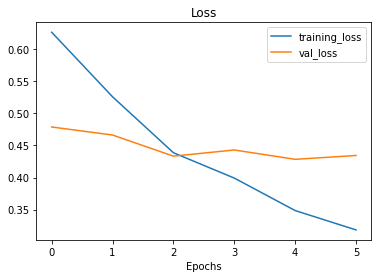

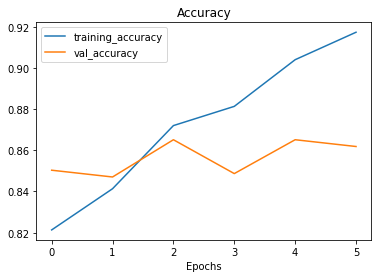

In [ ]:
# Check out the loss curves of our fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

Rge `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` (e.g. before and after fine-tuning)

In [ ]:
# Let's create a function to compare training histories
def comapre_histories(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects
  """
  # Get original history measurments
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

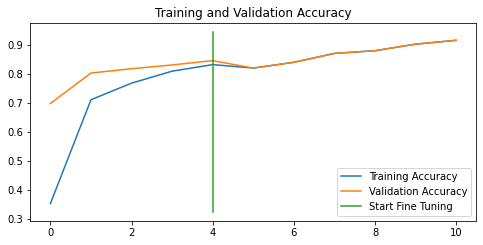

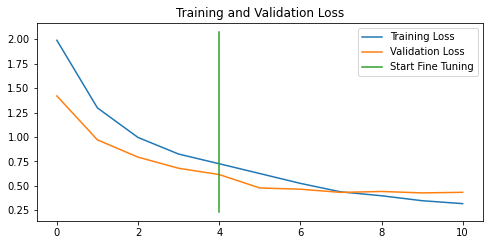

In [ ]:
comapre_histories(history_2, 
                  history_fine_10_percent_data_aug,
                  initial_epochs = 5)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 dta with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-11-17 15:20:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  63.4MB/s    in 6.9s    

2022-11-17 15:20:45 (72.1 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [ ]:
# Set up training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we looking at now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in, is the test we've been using for previous experiments (all experiments have used the same test dataset)

Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4223 - accuracy: 0.8600


[0.4222756326198578, 0.8600000143051147]

In [ ]:
results_fine_tune_10_percent

[0.4222755432128906, 0.8600000143051147]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6139 - accuracy: 0.8448


[0.6139376759529114, 0.8447999954223633]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6139374375343323, 0.8447999954223633]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we save the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2, except this time we're going to use all of the data.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base model_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 tf.math.truediv_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25*len(test_data)),
                                           initial_epoch = history_2.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                    experiment_name = "full_10_classes_fine_tune_all_data")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_all_data/20221117-152114
Epoch 5/10
235/235 [==============================] - 46s 169ms/step - loss: 0.6448 - accuracy: 0.7929 - val_loss: 0.3928 - val_accuracy: 0.8750
Epoch 6/10
235/235 [==============================] - 39s 164ms/step - loss: 0.5269 - accuracy: 0.8257 - val_loss: 0.3510 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 38s 159ms/step - loss: 0.4654 - accuracy: 0.8497 - val_loss: 0.3303 - val_accuracy: 0.8980
Epoch 8/10
235/235 [==============================] - 37s 156ms/step - loss: 0.4223 - accuracy: 0.8659 - val_loss: 0.3252 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 36s 150ms/step - loss: 0.3938 - accuracy: 0.8721 - val_loss: 0.3243 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 34s 141ms/step - loss: 0.3617 - accuracy: 0.8853 - val_loss: 0.3008 - val_accuracy: 0.9128


In [ ]:
# Let's evaluate on all of the test data
reslulat_fine_tune_full_data = model_2.evaluate(test_data)
reslulat_fine_tune_full_data

79/79 [==============================] - 6s 75ms/step - loss: 0.2744 - accuracy: 0.9100


[0.27435657382011414, 0.9100000262260437]

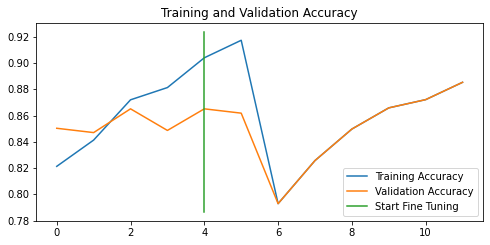

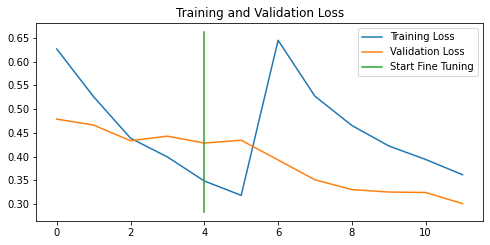

In [ ]:
# How did fine tuning go with more data?
comapre_histories(original_history = history_fine_10_percent_data_aug,
                  new_history = history_fine_10_classes_full,
                  initial_epochs = 5)

## Viewing our experiments data on TensorBoard

In [ ]:
# View TensorBoard logs of transfer learning modelling experiment(should be 5 models)
# Upload TensorBoard 
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "We did a series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exists the uploade once it finished uploading



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/5A0caKp0QZOpXOjVZTWpgA/

[2022-11-17T15:25:48] Started scanning logdir.
[2022-11-17T15:25:57] Total uploaded: 282 scalars, 0 tensors, 9 binary objects (7.5 MB)
[2022-11-17T15:25:57] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/5A0caKp0QZOpXOjVZTWpgA/


My TensorBoard experiments are avilable in https://tensorboard.dev/experiment/yY1vizGQSzyIObr79VKPRQ/#scalars

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
#!tensorboard dev list

https://tensorboard.dev/experiment/5A0caKp0QZOpXOjVZTWpgA/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          We did a series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   5A0caKp0QZOpXOjVZTWpgA
	Created              2022-11-17 15:25:48 (55 seconds ago)
	Updated              2022-11-17 15:25:57 (46 seconds ago)
	Runs                 18
	Tags                 5
	Scalars              282
	Tensor bytes         0
	Binary object bytes  7910729
https://tensorboard.dev/experiment/B1mjAfMLQveapT9D3jkhPQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          We did a series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   B1mjAfMLQveapT9D3jkhPQ
	Created              2022-11-17 15:25:20 (1 minute ago)
	Updated              2022-11-17 15:25:29 (1 minute ago)
	Runs                 18


In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id 5A0caKp0QZOpXOjVZTWpgA